# Test de l'opérateur ProblemDiscontinuEcomme3D

In [1]:
import sys
import os

lib_path = os.path.realpath(os.path.join(os.getcwd(), ".."))
if lib_path not in sys.path:
    sys.path = [lib_path] + sys.path

In [2]:
from src.main_discontinu import *
from src.plot_fields import *

%matplotlib notebook
rc("figure", figsize=(10, 5))
rc("figure", dpi=100)

## Paramètres de la simulation

Ici on va réaliser une simulation sans diffusion pour différentes écritures de notre équation thermique.

La résolution se fait à chaque fois en WENO avec Euler explicite en temps.

In [3]:
n_lim = 10**9
t_fin_lim = 0.2

In [4]:
# d = 6./100*Delta/2.
phy_prop = PhysicalProperties(
    Delta=0.02,
    v=0.2,
    dS=0.005**2,
    lda1=5.5 * 10**-2,
    lda2=15.5,
    rho_cp1=70278.0,
    rho_cp2=702780.0,
    diff=1.0,
    alpha=0.06,
    a_i=357.0,
)
phy_prop_sans_conv = PhysicalProperties(
    Delta=0.02,
    v=0.0,
    dS=0.005**2,
    lda1=5.5 * 10**-2,
    lda2=15.5,
    rho_cp1=70278.0,
    rho_cp2=702780.0,
    diff=1.0,
    alpha=0.06,
    a_i=357.0,
)
num_prop = NumericalProperties(
    dx=3.0 * 10**-5, schema="quick", time_scheme="euler", phy_prop=phy_prop, cfl=0.5
)
markers = BulleTemperature(phy_prop=phy_prop, x=num_prop.x, n_bulle=1)
markers.shift(0.00001)
# markers = Bulles(phy_prop=phy_prop)

dt fourier
4.0888316389624144e-06
Db / dx = 39
dt fourier
4.0888316389624144e-06
Db / dx = 39
Ti
ESP sans correction flux


<IPython.core.display.Javascript object>


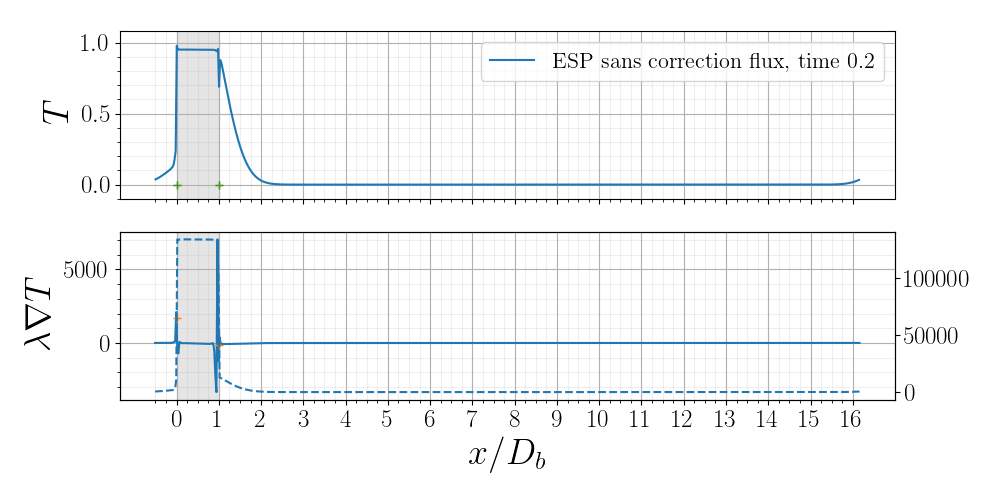

<IPython.core.display.Javascript object>


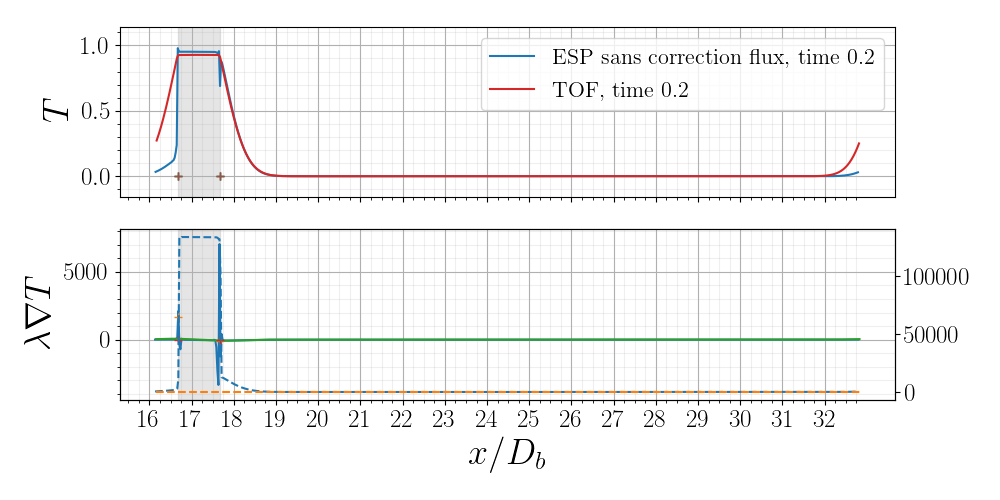

TOF


<IPython.core.display.Javascript object>


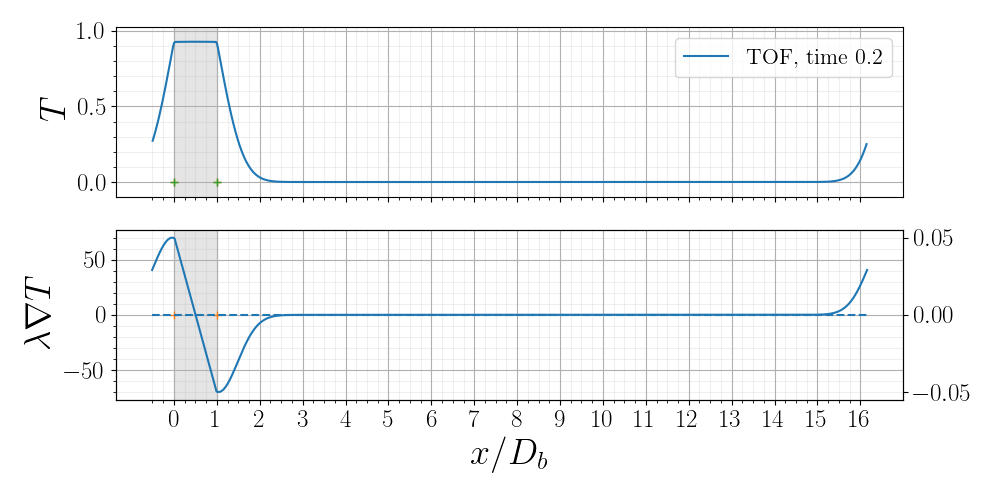

<IPython.core.display.Javascript object>


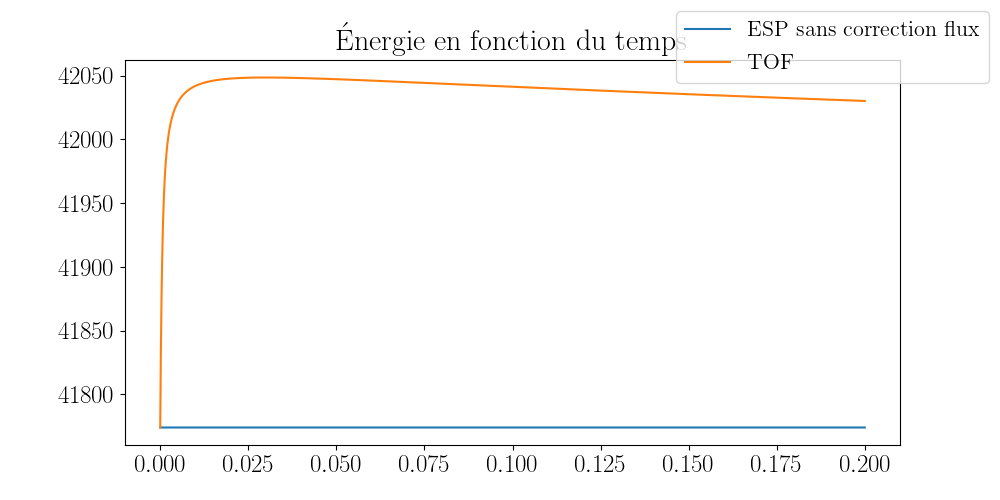

dE*/dt* = 4.24485e-21


In [9]:
t_fin = 0.2
prob_ref = Problem(
    get_T_creneau, markers=markers, phy_prop=phy_prop_sans_conv, num_prop=num_prop
)
prob = ProblemDiscontinuEcomme3D(
    get_T_creneau,
    markers=markers,
    phy_prop=phy_prop,
    num_prop=num_prop,
    interp_type="Ti",
)

plot_tot = Plotter("decale", flux_conv=True, lda_gradT=True)

E0 = prob.energy
print(prob.name)
print("==========================")
plot_1 = Plotter("classic", flux_conv=True, lda_gradT=True)
t, e = prob.timestep(
    t_fin=min(t_fin, t_fin_lim), n=n_lim, number_of_plots=1, plotter=[plot_1, plot_tot]
)

print(prob_ref.name)
print("==========================")
plot_2 = Plotter("classic", flux_conv=True, lda_gradT=True)
t_ref, e_ref = prob_ref.timestep(
    t_fin=min(t_fin, t_fin_lim), n=n_lim, number_of_plots=1, plotter=[plot_2, plot_tot]
)


fig1, ax1 = plt.subplots(1)
ax1.set_title("Énergie en fonction du temps")
l = ax1.plot(t, e / (0.02 * 0.005 * 0.005), label=prob.name)
l = ax1.plot(t_ref, e_ref / (0.02 * 0.005 * 0.005), label=prob_ref.name)
le = fig1.legend()

# plot.ax.plot(prob.bulles.markers.flatten(), prob.bulles.T.flatten(), 'r+')
# plot.ax.plot(prob.bulles.markers.flatten(), prob.bulles.Tg.flatten(), 'g+')
# plot.ax.plot(prob.bulles.markers.flatten(), prob.bulles.Td.flatten(), 'b+')

n = len(e)
i0 = int(n / 5)
dedt_adim = (e[-1] - e[i0]) / (t[-1] - t[i0]) * prob.dt / E0  # on a mult
# par Dt / rho_cp_l T_l V
print("dE*/dt* = %g" % dedt_adim)

## Comme 3D avec Ghost cell

Ici on va réaliser une simulation sans diffusion pour différentes écritures de notre équation thermique.

La résolution se fait à chaque fois en Quick avec Euler explicite en temps.

In [3]:
n_lim = 1 * 10**5
t_fin_lim = 2.0

In [4]:
# d = 6./100*Delta/2.
phy_prop = PhysicalProperties(
    Delta=0.02,
    v=0.2,
    dS=0.005**2,
    lda1=5.5 * 10**-2,
    lda2=15.5,
    rho_cp1=70278.0,
    rho_cp2=702780.0,
    diff=1.0,
    alpha=0.06,
    a_i=357.0,
)
phy_prop_sans_conv = PhysicalProperties(
    Delta=0.02,
    v=0.0,
    dS=0.005**2,
    lda1=5.5 * 10**-2,
    lda2=15.5,
    rho_cp1=70278.0,
    rho_cp2=702780.0,
    diff=1.0,
    alpha=0.06,
    a_i=357.0,
)
num_prop = NumericalProperties(
    dx=3.0 * 10**-5, schema="quick", time_scheme="euler", phy_prop=phy_prop, cfl=0.5
)
markers = BulleTemperature(phy_prop=phy_prop, x=num_prop.x, n_bulle=1)
markers.shift(0.00001)
# markers = Bulles(phy_prop=phy_prop)

dt fourier
4.0888316389624144e-06
Db / dx = 39
dt fourier
4.0888316389624144e-06
Db / dx = 39
Ti
ESP sans correction flux


<IPython.core.display.Javascript object>


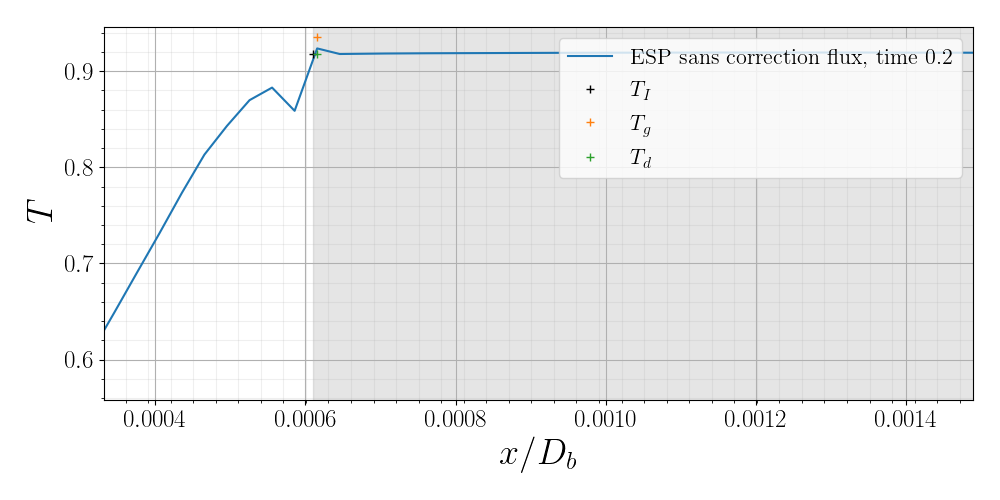

<IPython.core.display.Javascript object>


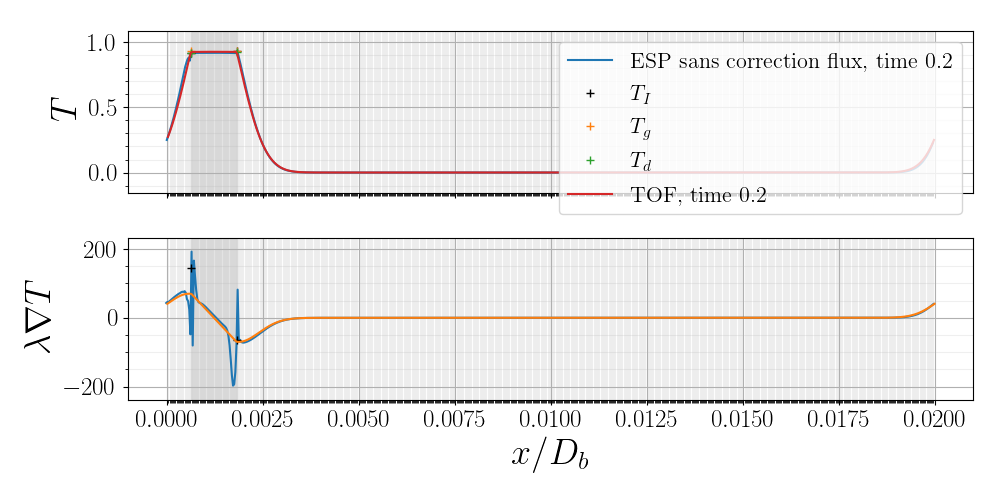

TOF


<IPython.core.display.Javascript object>


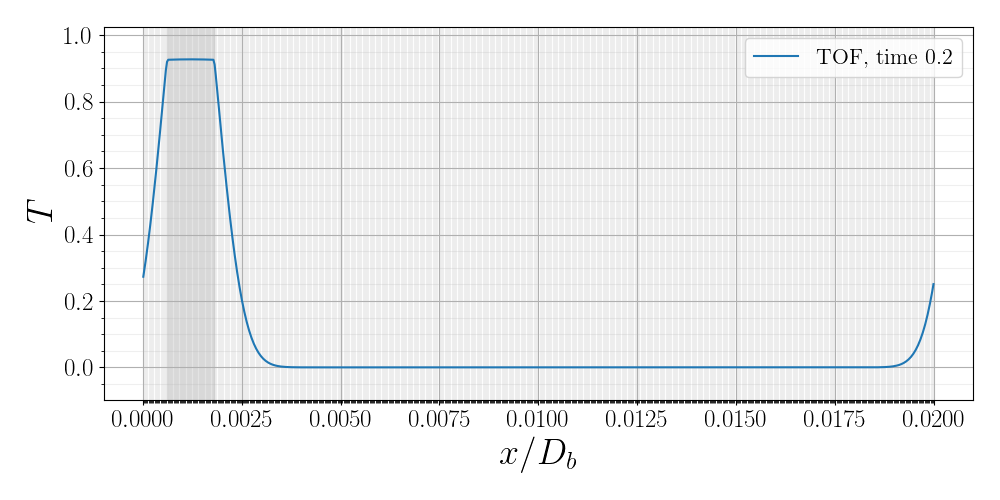

<IPython.core.display.Javascript object>


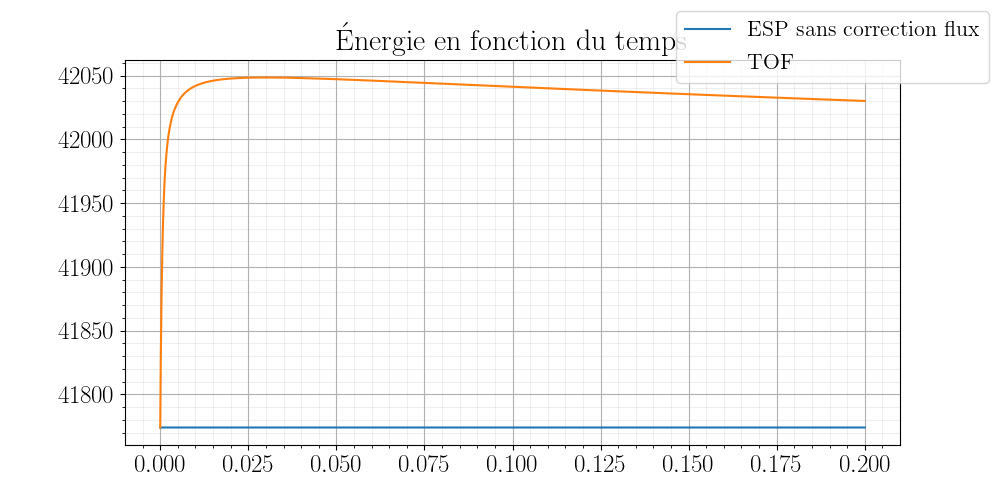

dE*/dt* = -7.21624e-20


In [5]:
t_fin = 0.2
prob_ref = Problem(
    get_T_creneau, markers=markers, phy_prop=phy_prop_sans_conv, num_prop=num_prop
)
prob = ProblemDiscontinuEcomme3D_ghost(
    get_T_creneau,
    markers=markers,
    phy_prop=phy_prop,
    num_prop=num_prop,
    interp_type="Ti",
)

plot_tot = Plotter("decale", flux_conv=False, lda_gradT=True)

E0 = prob.energy
print(prob.name)
print("==========================")
plot_1 = Plotter("classic", flux_conv=False, lda_gradT=False)
t, e = prob.timestep(
    t_fin=min(t_fin, t_fin_lim),
    n=n_lim,
    number_of_plots=1,
    plotter=[plot_1, plot_tot],
    plot_Ti=True,
    ispretty=False,
)

print(prob_ref.name)
print("==========================")
plot_2 = Plotter("classic", flux_conv=False, lda_gradT=False)
t_ref, e_ref = prob_ref.timestep(
    t_fin=min(t_fin, t_fin_lim),
    n=n_lim,
    number_of_plots=1,
    plotter=[plot_2, plot_tot],
    ispretty=False,
)


fig1, ax1 = plt.subplots(1)
ax1.set_title("Énergie en fonction du temps")
l = ax1.plot(t, e / (0.02 * 0.005 * 0.005), label=prob.name)
l = ax1.plot(t_ref, e_ref / (0.02 * 0.005 * 0.005), label=prob_ref.name)
ax1.minorticks_on()
ax1.grid(b=True, which="major")
ax1.grid(b=True, which="minor", alpha=0.2)
le = fig1.legend()

# plot.ax.plot(prob.bulles.markers.flatten(), prob.bulles.T.flatten(), 'r+')
# plot.ax.plot(prob.bulles.markers.flatten(), prob.bulles.Tg.flatten(), 'g+')
# plot.ax.plot(prob.bulles.markers.flatten(), prob.bulles.Td.flatten(), 'b+')

n = len(e)
i0 = int(n / 5)
dedt_adim = (e[-1] - e[i0]) / (t[-1] - t[i0]) * prob.dt / E0  # on a mult
# par Dt / rho_cp_l T_l V
print("dE*/dt* = %g" % dedt_adim)